In [28]:
import sys; sys.path.insert(0, '..')
import os
import pandas as pd
import numpy as np
import timesync_utils as tutils
import seaborn as sns
from matplotlib import pyplot as plt
from tabulate import tabulate
from df_utils import df_wrapper, get_timestamp_and_pose, POSE_MAP

In [29]:
train_csv_file = "../../data/train_data/martin_train_3_030221.csv"
train_annot_file = "../../data/annotation/training/martin_train_3_030221.txt"
test_csv_file = "../../data/test_data/martin_test_3_040221.csv"
test_annot_file = "../../data/annotation/testing/martin_test_3_040221.txt"

In [30]:
knn_train = df_wrapper(train_csv_file)
knn_train.concat_sensor_data(3)

knn_test = df_wrapper(test_csv_file)
knn_test.concat_sensor_data(3)

Splitting into  3  separate dataframes...
Fixing time offsets
Dropping unused columns...
Min length of sensor data:  54078
Splitting into  3  separate dataframes...
Fixing time offsets
Dropping unused columns...
Min length of sensor data:  4602


4602

drops: 0
length of knn_train.df after drops: 52824
52824
drops: 0
length of knn_train.df after drops: 4039
4039


<AxesSubplot:xlabel='Pose', ylabel='Count'>

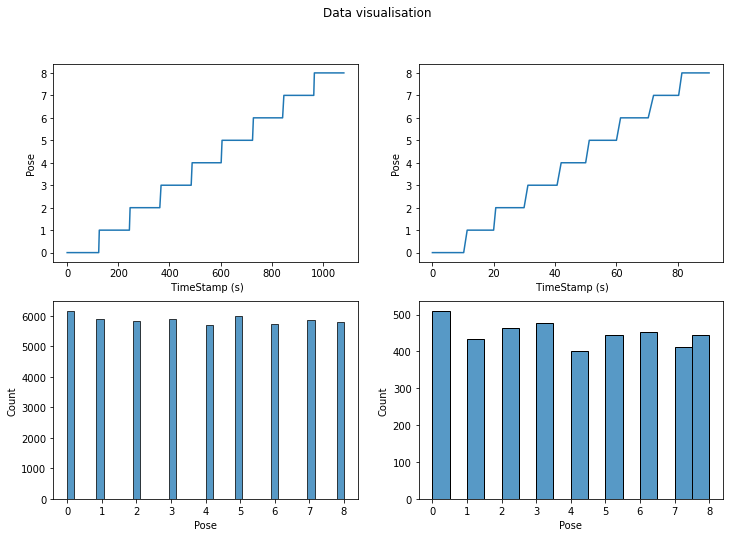

In [37]:
train_stamped_poses = get_timestamp_and_pose(train_annot_file, POSE_MAP)
knn_train.align_poses(train_stamped_poses)
y_train = knn_train.df["Pose"]

test_stamped_poses = get_timestamp_and_pose(test_annot_file, POSE_MAP)
knn_test.align_poses(test_stamped_poses)
y_test = knn_test.df["Pose"]
y_test.index = [i for i in range(len(y_test))]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Data visualisation')
sns.lineplot(ax=axes[0, 0], data=knn_train.df, x=" TimeStamp (s)", y='Pose')
sns.lineplot(ax=axes[0, 1], data=knn_test.df, x=" TimeStamp (s)", y='Pose')
sns.histplot(ax=axes[1, 0], data=y_train)
sns.histplot(ax=axes[1, 1], data=y_test)

In [38]:
x_train = knn_train.df.drop([' TimeStamp (s)', 'Pose'],axis=1)
x_test = knn_test.df.drop([' TimeStamp (s)', 'Pose'], axis=1) 

x_train_numpy = x_train.values
x_test_numpy = x_test.values

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(52824, 48)
(52824,)
(4039, 48)
(4039,)


### Keras Model

Leger en enkel modell

In [33]:
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf

LR = 0.01
EPOCH = 5_000
BATCH_SIZE = 1_000
AMOUNT_OF_SENSORS = 3
ACTIVATION1 = 'relu'
ACTIVATION2 = 'softmax'
#ACTIVATION2 = 'sigmoid'
OPTIM = 'adam'
#OPTIM = 'rmsprop'

def get_compiled_model(input_shape=(AMOUNT_OF_SENSORS*16)+1, output_shape=len(POSE_MAP), lr=LR):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(AMOUNT_OF_SENSORS, activation=ACTIVATION1),
        tf.keras.layers.Dense(int((AMOUNT_OF_SENSORS + output_shape)/2), activation=ACTIVATION1),
        tf.keras.layers.Dense(output_shape)
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer=OPTIM, metrics=['accuracy'])
    return model



In [34]:
model = get_compiled_model()
history = model.fit(np.array(x_train), np.array(y_train), epochs=EPOCH, batch_size=BATCH_SIZE, verbose=0)

In [39]:
#y_new = predict_classes(np.array(x_test))
y_new = np.argmax(model.predict(np.array(x_test)), axis=-1)
failed = [i for i in y_test.index if (y_test[i] != y_new[i])]

print(f"Precision: {100-(len(failed)/len(y_test))*100}")

Precision: 9.928200049517216


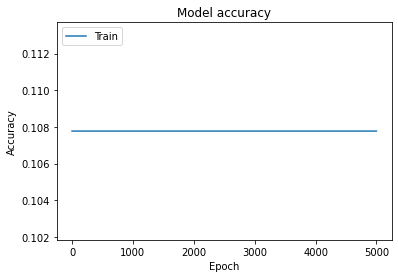

In [40]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()